In [142]:

#import libraries
from __future__ import division

from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans


import plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

import xgboost as xgb


In [143]:
import pandas as pd

In [144]:
df = pd.read_csv('customer_segmentation.csv/customer_segmentation.csv', encoding='unicode_escape')

In [145]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [146]:
df.shape

(541909, 8)

In [147]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [148]:
df.dropna(inplace=True)

In [149]:
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [150]:
df['InvoiceDate']= pd.to_datetime(df['InvoiceDate'])

In [151]:
# If we are looking for retention rate segmentation, then we can segment based on churn probability 


In [152]:
# We will be applying R-F-M  Model

In [153]:
df_user = pd.DataFrame(df['CustomerID'].unique())

In [154]:
df_user

,0
0,17850.0
1,13047.0
2,12583.0
3,13748.0
4,15100.0
...,...
4367,13436.0
4368,15520.0
4369,13298.0
4370,14569.0


In [155]:
df['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

In [156]:
df.groupby('CustomerID').agg('InvoiceDate').min().reset_index()

,CustomerID,InvoiceDate
0,12346.0,2011-01-18 10:01:00
1,12347.0,2010-12-07 14:57:00
2,12348.0,2010-12-16 19:09:00
3,12349.0,2011-11-21 09:51:00
4,12350.0,2011-02-02 16:01:00
...,...,...
4367,18280.0,2011-03-07 09:52:00
4368,18281.0,2011-06-12 10:53:00
4369,18282.0,2011-08-05 13:35:00
4370,18283.0,2011-01-06 14:14:00


In [157]:
ruser=abs(df['InvoiceDate'].max()-df.groupby('CustomerID').agg('InvoiceDate').min()).reset_index()

In [158]:
ruser.columns=['CustomerID', 'LastActive']

In [159]:
ruser['LastActive'] = ruser['LastActive'].map(lambda x : x.days)

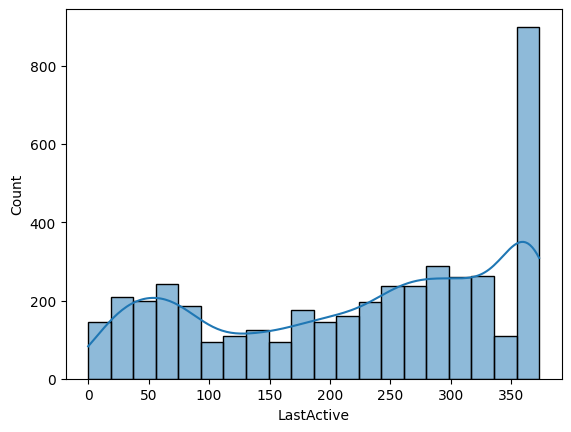

In [160]:
sns.histplot(ruser['LastActive'], bins=20, kde=True)
plt.show()

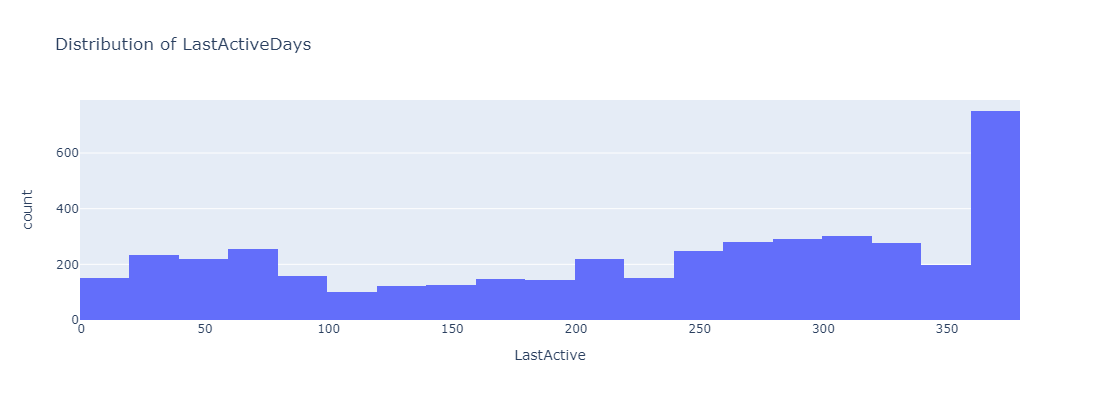

In [161]:
import plotly.express as px


# Create a histogram using Plotly Express
fig = px.histogram(ruser, x='LastActive', nbins=20, title='Distribution of LastActiveDays',
                   labels={'LastActiveDays': 'Number of Days Since Last Activity', 'count': 'Count'})
fig.update_layout(height=400, width=600)
fig.show()

In [162]:
ruser['LastActive']

0       325
1       366
2       357
3        18
4       309
       ... 
4367    277
4368    180
4369    125
4370    336
4371    201
Name: LastActive, Length: 4372, dtype: int64

In [163]:
fcount1=df.groupby('CustomerID').agg('InvoiceNo').count().reset_index()
fcount1

,CustomerID,InvoiceNo
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17
...,...,...
4367,18280.0,10
4368,18281.0,7
4369,18282.0,13
4370,18283.0,756


In [164]:
fcount2=((df.groupby('CustomerID').agg('InvoiceDate').max()-df.groupby('CustomerID').agg('InvoiceDate').min()).map(lambda x:x.days) + 1).reset_index()
fcount2

,CustomerID,InvoiceDate
0,12346.0,1
1,12347.0,366
2,12348.0,283
3,12349.0,1
4,12350.0,1
...,...,...
4367,18280.0,1
4368,18281.0,1
4369,18282.0,119
4370,18283.0,334


In [165]:
fuser = fcount1.join(fcount2.set_index('CustomerID'), on='CustomerID', how='inner')
# or use pd.merge 

In [166]:
#fuser['InvoiceDate'].map(lambda x : 1 if x==0 else x)

In [167]:
fuser['Frequency']=fuser['InvoiceNo']/fuser['InvoiceDate']

In [168]:
fuser['Frequency']

0        2.000000
1        0.497268
2        0.109541
3       73.000000
4       17.000000
          ...    
4367    10.000000
4368     7.000000
4369     0.109244
4370     2.263473
4371     0.440252
Name: Frequency, Length: 4372, dtype: float64

In [169]:
df['totalPrice']= abs(df['Quantity']*df['UnitPrice'])

In [170]:
muser=df.groupby('CustomerID').agg('totalPrice').sum().reset_index()

In [171]:
muser['AOV'] = muser['totalPrice']/fuser['InvoiceNo']

In [172]:
fuser

,CustomerID,InvoiceNo,InvoiceDate,Frequency
0,12346.0,2,1,2.000000
1,12347.0,182,366,0.497268
2,12348.0,31,283,0.109541
3,12349.0,73,1,73.000000
4,12350.0,17,1,17.000000
...,...,...,...,...
4367,18280.0,10,1,10.000000
4368,18281.0,7,1,7.000000
4369,18282.0,13,119,0.109244
4370,18283.0,756,334,2.263473


In [173]:
df['totalPrice'].sort_values()

446125         0.0
40089          0.0
479546         0.0
358655         0.0
47068          0.0
            ...   
222680     38970.0
61624      77183.6
61619      77183.6
540422    168469.6
540421    168469.6
Name: totalPrice, Length: 406829, dtype: float64

In [174]:
(df['totalPrice']<0).sum()

0

In [175]:
# ruser, muser, fuser, 

In [176]:
# Assign percentile rank to each category  
# Find Overall score 
# Overall score based ranking  
# Train model based on  R-F-M , AOV, -> Ranking based on Overall score 
# 

In [177]:
muser

,CustomerID,totalPrice,AOV
0,12346.0,154367.20,77183.600000
1,12347.0,4310.00,23.681319
2,12348.0,1797.24,57.975484
3,12349.0,1757.55,24.076027
4,12350.0,334.40,19.670588
...,...,...,...
4367,18280.0,180.60,18.060000
4368,18281.0,80.82,11.545714
4369,18282.0,179.50,13.807692
4370,18283.0,2094.88,2.771005


In [178]:
ruser.sort_values(by=['LastActive'], inplace=True)
ruser.reset_index(drop=True,inplace=True)
muser.sort_values(by=['AOV'], inplace=True)
muser.reset_index(drop=True,inplace=True)
fuser.sort_values(by=['Frequency'], inplace=True)
fuser.reset_index(drop=True,inplace=True)

In [179]:
ptile=[0.2, 0.4, 0.6, 0.8]



In [180]:
data = np.array([1, 2, 3, 4, 5, 121, 6, 7, 8, 9, 10, 11, 120])

# Calculate the median (50th percentile)
median = np.quantile(data, 0.5)

# Calculate the 25th and 75th percentiles
q25 = np.quantile(data, 1)
q75 = np.quantile(data, 0.75)

# Display the results
print(f"Median: {median}")
print(f"25th Percentile: {q25}")
print(f"75th Percentile: {q75}")

Median: 7.0
25th Percentile: 121
75th Percentile: 10.0


In [181]:
rmap=np.quantile(ruser['LastActive'], ptile, method='inverted_cdf' ) 

fmap=np.quantile(fuser['Frequency'], ptile, method='inverted_cdf' ) 

mmap=np.quantile(muser['AOV'], ptile, method='inverted_cdf' ) 

In [182]:
rmap

array([ 81, 210, 283, 357], dtype=int64)

In [183]:
def ranker(arr, mmap):
    if arr < mmap[0]:
        return 0
    elif mmap[1] > arr >= mmap[0]:
        return 1
    elif mmap[2] > arr >= mmap[1]:
        return 2
    elif mmap[3] > arr >= mmap[2]:
        return 3
    elif arr >= mmap[3]:
        return 4

def iranker(arr, mmap):
    if arr < mmap[0]:
        return 4
    elif mmap[1] > arr >= mmap[0]:
        return 3
    elif mmap[2] > arr >= mmap[1]:
        return 2
    elif mmap[3] > arr >= mmap[2]:
        return 1
    elif arr >= mmap[3]:
        return 0



In [184]:
#muser.head()  # Higher the AOV more valued 
#fuser.head()    # Higher the Frequency more valued 
#ruser.head()      # Lesser the LastActive better 


In [185]:
muser['mScore'] = muser['AOV'].apply(lambda x: ranker(x, mmap))
fuser['fScore'] = fuser['Frequency'].apply(lambda x: ranker(x, fmap))
ruser['rScore'] = ruser['LastActive'].apply(lambda x: iranker(x, rmap))

In [186]:
temp_df = pd.merge(muser, ruser, on='CustomerID', how='inner' )

In [187]:
final=pd.merge(temp_df, fuser, on='CustomerID', how='inner' )


In [188]:
final  # Note Higher the score the better it is 

,CustomerID,totalPrice,AOV,mScore,LastActive,rScore,InvoiceNo,InvoiceDate,Frequency,fScore
0,13256.0,0.00,0.000000,0,13,4,1,1,1.000000,2
1,16995.0,1.25,1.250000,0,371,0,1,1,1.000000,2
2,15503.0,147.09,2.101286,0,362,0,70,1,70.000000,4
3,17816.0,36.56,2.150588,0,364,0,17,329,0.051672,0
4,13684.0,70.23,2.265484,0,285,1,31,1,31.000000,4
...,...,...,...,...,...,...,...,...,...,...
4367,17448.0,4287.63,4287.630000,4,144,3,1,1,1.000000,2
4368,15749.0,67532.70,4502.180000,4,331,1,15,98,0.153061,0
4369,15098.0,79183.50,15836.700000,4,181,3,5,1,5.000000,3
4370,12346.0,154367.20,77183.600000,4,325,1,2,1,2.000000,3


In [189]:
#calculate overall score and use mean() to see details
Wf, Wr, Wm = 1, 1, 1

final['OverallScore'] = Wm*final['mScore'] +  Wf*final['fScore'] +  Wr*final['rScore']



In [190]:
# final.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

# Find top 8 groups and their score as lookup for further values 

In [191]:
df['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

In [192]:
df['InvoiceDate'].min()

Timestamp('2010-12-01 08:26:00')

In [193]:
df['NetRevenue'] = abs(df['UnitPrice']*df['Quantity'])

In [194]:
df.groupby('CustomerID')['NetRevenue'].mean().reset_index()

,CustomerID,NetRevenue
0,12346.0,77183.600000
1,12347.0,23.681319
2,12348.0,57.975484
3,12349.0,24.076027
4,12350.0,19.670588
...,...,...
4367,18280.0,18.060000
4368,18281.0,11.545714
4369,18282.0,13.807692
4370,18283.0,2.771005


In [195]:
filtered_df_6m = df[df['InvoiceDate'] < '2011-07-01 08:26:00'][['CustomerID', 'NetRevenue']]


In [196]:
filtered_df_6m.columns=['CustomerID' , 'NetRevenue6m']


In [197]:
filtered_df_6m = filtered_df_6m.groupby('CustomerID')['NetRevenue6m'].mean().reset_index()

In [198]:
filtered_df_6m.isna().sum()

CustomerID      0
NetRevenue6m    0
dtype: int64

In [199]:
final = pd.merge(final, filtered_df_6m, on='CustomerID', how='inner' )

In [200]:
final.columns = ['CustomerID', 'totalPrice', 'AOV', 'mScore', 'LastActive', 'rScore',
       'InvoiceNo', 'InvoiceDate', 'Frequency', 'fScore', 'OverallScore',
       'NetRevenue6m']

In [201]:
segment=[0.2, 0.45, 0.65,  0.85]
revmap=np.quantile(final['NetRevenue6m'], segment, method='inverted_cdf' ) 

In [202]:
revmap

array([10.33934426, 16.89402985, 20.99725   , 37.43257511])

In [203]:

final['LTV'] = final['NetRevenue6m'].apply(lambda x: ranker(x, revmap))

In [204]:
(final['NetRevenue6m']<0).sum()

0

In [205]:
dropCols=['CustomerID',  'InvoiceDate']
final.drop(columns=dropCols, inplace=True)

<Axes: >

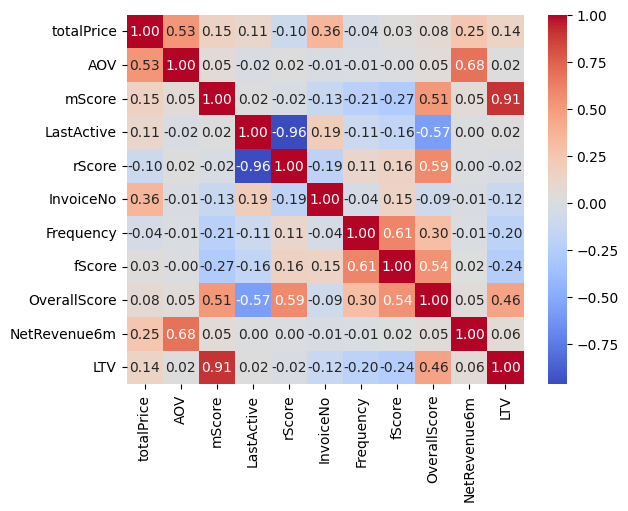

In [206]:
corr_matrix = final.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")

In [207]:
y= final['LTV']
X=final.drop(columns=['LTV'])

In [208]:
y.unique()

array([0, 1, 2, 3, 4], dtype=int64)

In [209]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [210]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [211]:
X_train.shape

(1680, 10)

In [212]:
import tensorflow as tf

In [213]:
X_train.shape[1:]

(10,)

In [214]:

norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])
model = tf.keras.Sequential([
        norm_layer,
        tf.keras.layers.Dense(300, activation="relu"), 
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.Dense(5, activation="softmax")  
        ])

#optimizer= tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
norm_layer.adapt(X_train)

In [215]:
history = model.fit(X_train, y_train, epochs=500, validation_data=(X_valid, y_valid)) 


Epoch 1/500
53/53 [==============================] - 1s 7ms/step - loss: 1.5716 - accuracy: 0.2565 - val_loss: 1.5132 - val_accuracy: 0.3981
Epoch 2/500
53/53 [==============================] - 0s 4ms/step - loss: 1.4692 - accuracy: 0.4458 - val_loss: 1.4247 - val_accuracy: 0.5118
Epoch 3/500
53/53 [==============================] - 0s 3ms/step - loss: 1.3822 - accuracy: 0.5375 - val_loss: 1.3433 - val_accuracy: 0.5562
Epoch 4/500
53/53 [==============================] - 0s 3ms/step - loss: 1.3017 - accuracy: 0.5708 - val_loss: 1.2696 - val_accuracy: 0.5603
Epoch 5/500
53/53 [==============================] - 0s 3ms/step - loss: 1.2280 - accuracy: 0.5756 - val_loss: 1.2032 - val_accuracy: 0.5784
Epoch 6/500
53/53 [==============================] - 0s 3ms/step - loss: 1.1637 - accuracy: 0.5958 - val_loss: 1.1468 - val_accuracy: 0.5867
Epoch 7/500
53/53 [==============================] - 0s 3ms/step - loss: 1.1087 - accuracy: 0.6262 - val_loss: 1.0993 - val_accuracy: 0.5978
Epoch 8/500
5

In [216]:
model.evaluate(X_test, y_test)

19/19 [==============================] - 0s 3ms/step - loss: 3.8804 - accuracy: 0.7854


[3.880363702774048, 0.7853577136993408]

In [217]:
X_new = X_test[:6]
y_pred = model.predict(X_test) 

19/19 [==============================] - 0s 2ms/step


In [218]:
y_test[:6]

2786    4
2148    3
1410    2
251     0
2506    3
2115    3
Name: LTV, dtype: int64

In [219]:
y_pred.shape,X_test.shape



((601, 5), (601, 10))

In [220]:
y_pred.argmax(axis=1)-y_test

2786    0
2148    0
1410    0
251     0
2506    0
       ..
1047    0
599     1
1809    0
1909    0
642     0
Name: LTV, Length: 601, dtype: int64

In [221]:
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [222]:
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Train the model on the training data
gb_clf.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [226]:
y_pred_valid = gb_clf.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred_valid)
print(f'Mean Squared Error: {accuracy}')

Mean Squared Error: 1.0


In [227]:
y_pred = gb_clf.predict(X_test)

In [228]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Mean Squared Error: {accuracy}')

Mean Squared Error: 0.9983361064891847
